In [1]:
!pip3 install nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import pandas as pd
import re
import string
import csv

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


[nltk_data] Downloading package punkt to /Users/pmd2137/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pmd2137/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import sys
print(sys.executable)

/usr/local/Cellar/jupyterlab/3.0.12/libexec/bin/python3.9


In [3]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [4]:
#read in data file
data = pd.read_csv('whole_clean_df.csv')
#list(data.columns)

In [99]:
#data['date']
#data['date']>'2020-6-1'
data['date']>'2021-06-1'

0        False
1        False
2        False
3        False
4        False
         ...  
66545     True
66546     True
66547     True
66548     True
66549     True
Name: date, Length: 66550, dtype: bool

In [14]:
stop_words_1 = stopwords.words('english') + ['i', 'u','I','the','s',',','’']
stop_words_2 = stopwords.words('english') + ['i', 'u','I','the','the','s',',','’','got','covid','vaccine','vaccines', 'covid vaccine', 'covidvaccine', 'moderna','pfizer','sinopharm','sinovac','dose','jab']

In [6]:
from nltk.tokenize import word_tokenize

data['lemma_sw_1'] = data['lemma'].apply(word_tokenize)
#apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
data['lemma_sw_1'] = data['lemma_sw_1'].apply(lambda words:' '.join([word for word in words if word not in stop_words_]))

NameError: name 'stop_words_' is not defined

In [17]:
from nltk.tokenize import word_tokenize

data['lemma_sw_2'] = data['lemma'].apply(word_tokenize)
#apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
data['lemma_sw_2'] = data['lemma_sw_2'].apply(lambda words: ' '.join([word for word in words if word not in stop_words_2]))

## EDA

In [10]:
data.groupby(['compound']).size().reset_index(name='counts')\
  .sort_values('counts', ascending=False).head(10)

,compound,counts
789,0.0000,25145
1227,0.4767,1971
1181,0.4215,1740
1195,0.4404,1718
497,-0.3818,1656
1113,0.3612,1393
1159,0.4019,1074
1075,0.3182,887
1365,0.5859,840
566,-0.2960,757


In [4]:
data.groupby(['hashtags']).size().reset_index(name='counts')\
  .sort_values('counts', ascending=False).head(10)

,hashtags,counts
10490,['Moderna'],4026
5022,['Covaxin'],3051
14629,['SputnikV'],1608
1877,['COVAXIN'],1504
13604,['Sinopharm'],1123
2875,['COVID19'],1045
18770,['moderna'],763
13972,['Sinovac'],705
17082,['covaxin'],550
11828,"['Pfizer', 'Moderna']",405


In [5]:
data.groupby(['Country']).size().reset_index(name='counts')\
  .sort_values('counts', ascending=False).head(10)

,Country,counts
155,USA,22673
68,India,21575
28,Canada,4478
113,Pakistan,1512
142,Sri Lanka,1395
32,China,1268
159,United Kingdom,905
91,Malaysia,888
117,Philippines,820
8,Australia,707


In [12]:
data.groupby(['Country']).size().reset_index(name='counts')\
  .sort_values('counts', ascending=False).head(10)

,Country,counts
155,USA,22673
68,India,21575
28,Canada,4478
113,Pakistan,1512
142,Sri Lanka,1395
32,China,1268
159,United Kingdom,905
91,Malaysia,888
117,Philippines,820
8,Australia,707


## Topic Modelling (LDA)

In [18]:
def print_top_words(model, feature_names, n_top_words):
    
    print("\nTopics in LDA model:")
    
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))                        
    print()

In [19]:
def runLDA(df_col_mood, n_topics):
    
    #import necessary packages
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.decomposition import LatentDirichletAllocation
    
    # the vectorizer object will be used to transform text to vector form
    vectorizer = CountVectorizer(max_df=0.9, min_df=100, token_pattern='\w+|\$[\d\.]+|\S+')

    # apply transformation
    #tf = vectorizer.fit_transform(data['text_no_sw']) #.toarray()
    tf = vectorizer.fit_transform(df_col_mood) #.toarray()

    # tf_feature_names tells us what word each column in the matric represents
    tf_feature_names = vectorizer.get_feature_names()
    tf.shape # --> (200000, 2296)
    
    #select number of topics and instantiate model
    number_of_topics = n_topics
    model = LatentDirichletAllocation(n_components=number_of_topics, random_state=315) # random state for reproducibility

    # Fit data to model
    model.fit(tf)
    
    #print feature names
    print_top_words(model, tf_feature_names, 20)
    
    # define vocabulary to get words names 
    vocab = vectorizer.get_feature_names()

    # dictionary to store words for each topic and number of words per topic to retrive 
    words = {}
    n_top_words = 10
    
    import numpy as np
    
    for topic, component in enumerate(model.components_):

        # need [::-1] to sort the array in descending order
        indices = np.argsort(component)[::-1][:n_top_words]

        # store the words most relevant to the topic
        words[topic] = [vocab[i] for i in indices]
    
    return model,tf_feature_names

In [20]:
data_positive = data[data['pos']> 0.05]
data_neg = data[data['compound']< -0.05]

In [21]:
data_neutral = data[data['compound']> -0.05]
data_neutral = data_neutral[data_neutral['compound']< 0.05]

In [22]:
lda_model_positive = runLDA(data_positive['lemma_sw_2'], 5)


Topics in LDA model:
Topic #0:
'vaccine 'the 'covid 'sinopharm 'use 'emergency 'health 'approved 'sinovac 'man 'sputnikv 'china 'good 'day 'approval 'dos 'vaccinated 'an 'receiving 'india
Topic #1:
'moderna 'got 'dose 'shot 'vaccine 'first 'today 'second 'vaccinated 'nd 'covid 'thank 'booster 'day 'covidvaccine 'm 'get 'fully 'feel 'done
Topic #2:
'vaccine 'moderna 'covid 'pfizer 'people 'get … 's 'it 'we 'like 'please 'sputnikv 'safe 'mrna 't 'one 'want 'take 'vaccinated
Topic #3:
'age 'dose 'slot 'covaxin 'date 'all '₹ 'pincode 'fee v 'miracle 'sputnik 'dr 'sep 'hospital 'united 'hea… 'aug 'me… h
Topic #4:
'covaxin 'vaccine 'india 'approval 'who 'covid 'effective 'news 'study 'covishield 'bharat 'biotech 's 'variant 'trial 'get '… 'indian 'data 'approved



Topic#  1
Topic#  2
Topic#  3
Topic#  4
Topic#  5


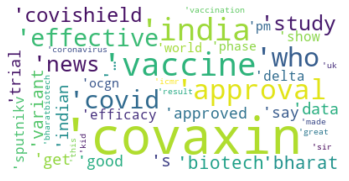

In [26]:
#declaring number of terms we need per topic
terms_count = 100
model = lda_model_positive[0]
tf_feature_names = lda_model_positive[1]

for idx,topic in enumerate(model.components_):
    print('Topic# ',idx+1)
    abs_topic = abs(topic)
    topic_terms = [[tf_feature_names[i],topic[i]] for i in abs_topic.argsort()[:-terms_count-1:-1]]
    topic_terms_sorted = [[tf_feature_names[i], topic[i]] for i in abs_topic.argsort()[:-terms_count - 1:-1]]
    topic_words = []
    
    for i in range(terms_count):
        topic_words.append(topic_terms_sorted[i][0])
            #print(','.join( word for word in topic_words))
            #print("")
        dict_word_frequency = {}

    for i in range(terms_count):
        dict_word_frequency[topic_terms_sorted[i][0]] = topic_terms_sorted[i][1]
        wcloud = WordCloud(background_color="white",mask=None, max_words=100,\
        max_font_size=60,min_font_size=10,prefer_horizontal=0.9,
        contour_width=3,contour_color='black')
        wcloud.generate_from_frequencies(dict_word_frequency)
        plt.imshow(wcloud, interpolation='bilinear')
        plt.axis("off")
        plt.savefig("positive_Topic#"+str(idx+1), format="png")


In [28]:
lda_model_neg = runLDA(data_neg['lemma_sw_2'], 5)


Topics in LDA model:
Topic #0:
'man 'vaccinated 'sinopharm 'the 'health 'day 'receiving 'vaccine 'died 'good 'yearold 'an 'had… 'fully 'in 'news 'the… 'get 'two 'jab
Topic #1:
'canada 'case 'ontario 'toronto 'embarrassing 'new 'forced 'covid 'reporting 'trudeau 'ford 'doug 'alone 'stay 'who 'eating 'home 'vaccine 'politicizing 'lockdown
Topic #2:
'russia 'everything 'open 'business 'usual 'embarrassing 'reporting 'ontario 'case 'sputnikv 'vaccination 'moscow 'of… 'people 'we … 'need 'govt 'adverse 'also
Topic #3:
'vaccine 'covaxin 'covid 'use 'emergency 'the 'india 's 'sinovac 'who … 'get 'sputnikv 'people 'country 'china '… 'covishield 'it 'fda
Topic #4:
'moderna 'vaccine 'shot 'dose 'got 'pfizer 'covid 'arm 'first 'second 'sore 'nd 'day 'effect 'side 'get 'no … 'today 'hour



Topic#  1
Topic#  2
Topic#  3
Topic#  4
Topic#  5


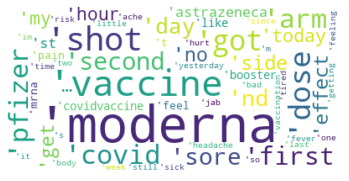

In [29]:
#declaring number of terms we need per topic
terms_count = 100
model = lda_model_neg[0]
tf_feature_names = lda_model_neg[1]

for idx,topic in enumerate(model.components_):
    print('Topic# ',idx+1)
    abs_topic = abs(topic)
    topic_terms = [[tf_feature_names[i],topic[i]] for i in abs_topic.argsort()[:-terms_count-1:-1]]
    topic_terms_sorted = [[tf_feature_names[i], topic[i]] for i in abs_topic.argsort()[:-terms_count - 1:-1]]
    topic_words = []
    
    for i in range(terms_count):
        topic_words.append(topic_terms_sorted[i][0])
        #print(','.join( word for word in topic_words))
        #print("")
        dict_word_frequency = {}

    for i in range(terms_count):
        dict_word_frequency[topic_terms_sorted[i][0]] = topic_terms_sorted[i][1]
        wcloud = WordCloud(background_color="white",mask=None, max_words=100,\
        max_font_size=60,min_font_size=10,prefer_horizontal=0.9,
        contour_width=3,contour_color='black')
        wcloud.generate_from_frequencies(dict_word_frequency)
        plt.imshow(wcloud, interpolation='bilinear')
        plt.axis("off")
        plt.savefig("neg_Topic#"+str(idx+1), format="png")

In [105]:
pre_data = data[(data['date']<'2021-06-1')]
post_data = data[(data['date']>'2021-06-1')]

data_positive_post_june_21 = pre_data[(pre_data['pos']>0) and (data['date']>'2021-06-1')]
data_positive_pre_june_21 = post_data[post_data['pos']>0 and data['date']<='2021-06-1']

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
data_neg_post_june_21 = data[data['neg']>0 && data['date']>'2021-06-01']
data_neg_pre_june_21 = data[data['neg']>0 && data['date']<='2021-06-01']

In [ ]:
# define vocabulary to get words names 
vocab = vectorizer.get_feature_names()

# dictionary to store words for each topic and number of words per topic to retrive 
words = {}
n_top_words = 10

for topic, component in enumerate(model.components_):

    # need [::-1] to sort the array in descending order
    indices = np.argsort(component)[::-1][:n_top_words]

    # store the words most relevant to the topic
    words[topic] = [vocab[i] for i in indices]

In [22]:
lda_model_neutral = runLDA(data_neutral['lemma'], 20)


Topics in LDA model:
Topic #0:
'world', 'covaxin', 'expert', 'group', 'approve', ['the', 'let', 'need', 'pandemic', 'price', 'committee', 'panel', 'heal', '…'] ['we', 'government', 'fight', ['let', 's', 'country',
Topic #1:
'case', 'new', 'covid', 'canada', 'toronto', 'reporting', 'ontario', 'politicizing', 'vaccine', ['embarrassing', 'home', 'school', 'stop', 'lockdown', ['canada', 'business', 'family', ['while', 'politicizing…'] 'stay',
Topic #2:
'dose', 'covaxin', 'nd', 'available', 'st', 'th', 'pm', 'took', 'vaccine', 'minister', 'administered', 'take', 'june', 'may', ['vaccine', 'delhi', 'due', 'taken', 'modi', 'second',
Topic #3:
'sputnikv', 'vaccine', 'covid', 'russia', 'o…'] 'country', 'astrazeneca', 'russian', 'eu', 'sale', 'say', 'contact', 'start', 'supply', 'syrinx', ['selling', 'facemasks', 'nitrilegloves', 'produce', 'chief',
Topic #4:
'moderna', 'vaccine', 'pfizer', 'covid', 'booster', 'shot', 'mrna', ['moderna', 'astrazeneca', 'fda', 'say', ['pfizer', 'moderna…'] 'stud

In [20]:
lda_model_neg = runLDA(data_neg['lemma'], 20)

## Splitting Based on Emotions

In [26]:
data_positive = data[data['Emotion'].str.contains("positive")]
data_trust = data[data['Emotion'].str.contains("trust")]
data_fear = data[data['Emotion'].str.contains("fear")]
data_negative = data[data['Emotion'].str.contains("negative")]
data_anger = data[data['Emotion'].str.contains("anger")]
data_anticipation = data[data['Emotion'].str.contains("anticipation")]
data_disgust = data[data['Emotion'].str.contains("disgust")]
data_joy = data[data['Emotion'].str.contains("joy")]

## Topics by Emotion

In [52]:
#all
lda_model_all = runLDA(data['lemma'], 100)


Topics in LDA model:
Topic #0:
'’', 's', 'it', 'vaccine', 'moderna', 'covid', 'maybe', 'matter', '…'] 'what', 'pfizerbiontech', 'announced', 'a…'] 'vaccination', ['moderna', 's…'] 'covidvaccine', 'know', 'say', 'soon',
Topic #1:
'country', 'f…'] 'for…'] 'using', 'become', 'working', 'others', 'america', 'vaccine', 'approve', 'start', 'vaccination', 'covid', 'one', 'a…'] 't…'] 'to…'] 'covaxin', 'vaccine…'] 'a',
Topic #2:
'minister', 'delhi', 'he', 'prime', 'aiims', 'covaxin', 'dose', ['sir', 'covid', 'first', 'vaccine', 'took', 'second', 'modi', ['pm', 'today', 'take', 'say', '…'] 'covidvaccine',
Topic #3:
'o…'] 'vaccine', 'sale', 'contact', 'sputnikv', 'syrinx', ['selling', 'facemasks', 'nitrilegloves', 'buy', 'have', 'suspended', ['while', ['indian', 'embarrassing', 'country', 'astrazeneca', 'say', 'trudeau', 'w…']
Topic #4:
'getting', 'moderna', 'vaccine', 'getvaccinated', 'foreign', 'japan', 'covid', ['japan', 'shot', 'second', ['im', 'tomorrow', 'dose', 'people', 'the…'] ['moderna

In [50]:
#data_positive
lda_model_anger = runLDA(data_positive['lemma'], 5)


Topics in LDA model:
Topic #0:
'moderna', 'dose', 'covid', 'jab', 'nd', 'pfizer', 'vaccine', 'day', 'second', 'get', 'st', 'like', 'first', ['got', 'vaccinated', 'moderna'] 'got', ['i', 'i', 'covidvaccine',
Topic #1:
'sore', 'arm', 'shot', 'moderna', 'side', 'i', 'effect', 'got', 'day', 'first', ['i', 'second', 'nd', 'vaccine', ['got', 'moderna'] 'st', 'covidvaccine', 'today', 'like',
Topic #2:
'covaxin', 'jab', 'vaccine', 'covid', 'vaccination', 'covidvaccine', 'st', 'first', 'get', 'got', ['got', ['i', 'today', 'day', 'nd', 'second', 'done', 'sinovac', 'vaccinated', 'dose',
Topic #3:
'i', '’', 's', ['i', 'like', 'got', 'get', 'moderna'] 'moderna', 'second', 'jab', 'vaccinated', 'day', 'first', 'dose', 'vaccine', 'pfizer', 'covid', 'side', 'st',
Topic #4:
'jab', 'first', 'today', ['got', 'vaccinated', 'sinovac', 'done', 'second', 'get', 'got', 'moderna'] 'moderna', 'vaccine', 'like', ['i', 'day', 'covidvaccine', 'st', 'nd', 'covid',



In [53]:
#data_positive
lda_model_positive = runLDA(data_positive['lemma'], 5)


Topics in LDA model:
Topic #0:
'vaccine', 'sputnikv', 'covid', 'india', 'v', 'sputnik', 'russia', ['moderna', 'production', 'o…'] 'russian', 'start', 'available', 'country', 'dr', 'contact', 'sale', 'group', 'age', 'coronavirus',
Topic #1:
'vaccine', '’', 'covid', 'moderna', 'pfizer', 's', 'covaxin', 'study', 'efficacy', 'effective', 'trial', 'say', 'data', 'new', 't', 'phase', 'show', 'variant', 'mrna', 'm',
Topic #2:
'vaccine', 'dose', 'first', 'sinopharm', 'covid', 'day', 'man', 'moderna', 'dos', 'vaccinated', 'the', 'received', 'today', 'health', 'good', 'receiving', 'second', 'died', ['an', 'yearold',
Topic #3:
'vaccine', 'covaxin', 'covid', 'approval', 'dos', 'sinovac', 'sinopharm', 'china', 'india', 'million', 'who', 'use', ['the', 'covishield', 'approved', 'chinese', 'biotech', 'emergency', 'get', '…']
Topic #4:
'vaccine', 'i', 'moderna', 'get', 'covid', 'got', ['i', 'dose', 'vaccinated', 'people', 'covaxin', 'one', 'first', 'shot', 'today', 'take', 'second', 'getting', 'nd', 

In [54]:
#data_trust
lda_model_trust = runLDA(data_trust['lemma'], 5)


Topics in LDA model:
Topic #0:
'dose', 'covaxin', 'hospital', 'nd', 'first', 'second', ['finally', 'st', 'got', 'today', 'motherhood', 'please', 'school', 'sir', 'united', 'state', 'system', ['good', 'done', 'covaxin']
Topic #1:
'russia', 'open', 'business', 'usual', 'everything', 'ontario', 'reporting', 'case', 'canada', 'of…'] 'moscow', ['moscow', ['embarrassing', 'covid', '…'] 'covid…'] 'new', 'president', 'pfizerbiontech', 'sputnikv',
Topic #2:
'’', 'vaccinated', 'i', 'moderna', 's', 'fully', 'covaxin', ['i', 'world', 'moderna'] 'get', 't', 'got', 'good', 'it', 'expert', 'let', 'heal', 'today', 'pfizer',
Topic #3:
'age', 'date', 'slot', '₹', 'fee', ['pincode', 'dose', 'covaxin', 'all', 'miracle', ['fully', 'sep', 'aug', 'hea…'] 'jul', 'v', 'sputnik', 'oct', 'h…'] 'united',
Topic #4:
'vaccine', 'covid', 'covaxin', 'moderna', 'effective', 'vaccination', ['the', 'india', 'sputnikv', 'dos', 'u', 'sinopharm', 'pfizer', 'covishield', 'sinovac', 'health', 'the', ['covaxin', 'trial', 'say

In [ ]:
#data_fear
lda_model_fear = runLDA(data_fear['lemma'], 5)

In [ ]:
#data_negative
lda_model_negative = runLDA(data_negative['lemma'], 5)

In [ ]:
#data_anger
lda_model_anger = runLDA(data_anger['lemma'], 5)

In [ ]:
#data_anticipation
lda_model_anticipation = runLDA(data_anticipation['lemma'], 5)

In [ ]:
#data_joy
lda_model_joy = runLDA(data_joy['lemma'], 5)


Topics in LDA model:
Topic #0:
'moderna', 'pfizer', 'vaccines', 'covid', 'vaccine', 'risk', 'pfizerbiontech', 'mrna', 'astrazeneca', 'shots', 'fda', 'infection', 'shot', ['nd', ['covid', 'get', 'the', 'you', 'us', 'go',
Topic #1:
'hospital', 'dose', 'age', 'slots', 'covaxin', 'date', '₹', 'fees', ['pincode', 'jul', 'aug', 'city', 'world', 'sakra', 'e', 'kauvery', 'wes…'] 'a…'] 'sep', '…']
Topic #2:
'pandemic', ['the', 'covid', 'take', 'still', 'so', 'this', 'time', 'vaccine', 'world', 'covaxin'] 'bad', 'pm', 'vaccinated', 'first', 'the…'] 'we', 'also', 'took', 'day',
Topic #3:
'’', 's', '…'] 'it', 't', 'next', 'week', 'shot', 'vaccine', 'we', 'booster', 'moderna', ['moderna', 'fda', 'news', 'says', 'day', 'covid', 'a…'] ['my',
Topic #4:
'covaxin', 'dose', 'slots', 'age', 'date', '₹', 'fees', ['pincode', 'hospital', 'medical', 'aug', 'west', 'suguna', 'c', 'sep', 'jul', 'bb…'] 'bg', 'rainbow', 'aster',
Topic #5:
'sputnikv', 'know', 't…'] 'not', 's…'] 'government', 'people', 'day', 'you

## Hashtag Analysis & Heatmap

In [ ]:
# take hashtags which appear at least this amount of times
min_appearance = 1000

# find popular hashtags - make into python set for efficiency
popular_hashtags_set = set(popular_hashtags[
                           popular_hashtags.counts>=min_appearance
                           ]['hashtag'])